This notebook represents a prototypical python 3 implementation for a without safeguards, without asserts, with fixed paramterized model. For larger data sets it is advised to store intermediate results, e.g. as pickle files.

Theory https://towardsdatascience.com/effortlessly-recommending-similar-images-b65aff6aabfb



# Rescaling

We assume to have a folder "originalImages" in the working directory. It shall contain jpg images.
As we will employ resnet18 using PyTorch, we need to resize the images to normalized 224x224 images
In a first step they are resized and stored in a different folder inputImagesCNN

In [1]:
import os
from PIL import Image
from torchvision import transforms

# needed input dimensions for the CNN
inputDim = (224,224)
inputDir = "originalImages"
inputDirCNN = "inputImagesCNN"
searchDir = "searchDir"

os.makedirs(inputDirCNN, exist_ok = True)

# clear inputDirCnn folder
for f in os.listdir(inputDirCNN):
    if not f.endswith(".jpg"):
        continue
    os.remove(os.path.join(inputDirCNN, f))



def resizeAndSaveToInputDirCNN(inputDir, imageName, inputDirCNN):
    transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])
    
    I = Image.open(os.path.join(inputDir, imageName))
    newI = transformationForCNNInput(I)

    # copy the rotation information metadata from original image and save, else your transformed images may be rotated
    if "exif" in I.info:
        exif = I.info['exif']
        newI.save(os.path.join(inputDirCNN, imageName), exif=exif)
    else:
        newI.save(os.path.join(inputDirCNN, imageName))
    
    newI.close()
    I.close()
    return



for imageName in os.listdir(inputDir):
    resizeAndSaveToInputDirCNN(inputDir, imageName, inputDirCNN)
    #     I = Image.open(os.path.join(inputDir, imageName))
    #     newI = transformationForCNNInput(I)

    #     # copy the rotation information metadata from original image and save, else your transformed images may be rotated
    #     if "exif" in I.info:
    #         exif = I.info['exif']
    #         newI.save(os.path.join(inputDirCNN, imageName), exif=exif)
    #     else:
    #         newI.save(os.path.join(inputDirCNN, imageName))

    #     newI.close()
    #     I.close()

# Creating the similarity matrix with Resnet18

Let us first calculate the feature vectors with resnet18 on a CPU. The input is normalized to the ImageNet mean values/standard deviation.

In [2]:
import torch
from tqdm import tqdm
from torchvision import models

# for this prototype we use no gpu, cuda= False and as model resnet18 to obtain feature vectors

class Img2VecResnet18():
    def __init__(self):
        
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] --> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer
        

def convertImageToFeatureVector(image, vectors):
    I = Image.open(os.path.join(inputDirCNN, image))
    vec = img2vec.getVec(I)
    vectors[image] = vec
    I.close() 
    return
        
# generate vectors for all the images in the set
img2vec = Img2VecResnet18() 

allVectors = {}
print("Converting images to feature vectors:")
for image in tqdm(os.listdir(inputDirCNN)):
    #     I = Image.open(os.path.join(inputDirCNN, image))
    #     vec = img2vec.getVec(I)
    #     allVectors[image] = vec
    #     I.close() 
    convertImageToFeatureVector(image, allVectors)


  1%|█                                                                                  | 1/82 [00:00<00:12,  6.32it/s]

Converting images to feature vectors:


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [00:06<00:00, 12.32it/s]


{'20150703_0805_18.jpg': array([3.9048094e-01, 1.9945498e+00, 3.2247868e-01, 5.6114638e-01,
       1.4454927e+00, 1.1621548e+00, 1.3557459e+00, 8.5730082e-01,
       1.4709533e-02, 5.6662297e-01, 6.0658234e-01, 3.7460265e-01,
       2.0519331e+00, 1.0417125e+00, 9.1261470e-01, 2.3175539e-02,
       4.8436442e-01, 1.2417701e-01, 9.4974928e-02, 1.0833883e+00,
       2.3569848e-02, 4.0289775e-01, 1.0892535e+00, 9.2650658e-01,
       2.6728100e-01, 7.5865880e-02, 6.6891056e-01, 6.0391515e-01,
       0.0000000e+00, 2.1190698e-01, 1.6001000e+00, 1.9999187e-02,
       2.3951627e-01, 4.0025026e-01, 4.4806886e-01, 7.3493224e-01,
       4.9785948e-01, 3.9430458e-02, 9.9953555e-02, 1.3369352e-01,
       1.1224351e+00, 5.7216436e-01, 6.3497174e-01, 1.0432547e+00,
       1.7712045e+00, 1.6552598e+00, 9.3040943e-01, 2.5078416e-01,
       1.5165188e+00, 8.2536596e-01, 8.6602074e-01, 2.0791182e-01,
       1.1452883e+00, 1.5144982e+00, 9.1631472e-02, 1.3920064e+00,
       3.0627355e-01, 3.0759636e-01, 

# Cosine similarity
Calculate for all vectors the cosine similarity to the other vectors.
Note that this matrix may become huge, hence infefficient, with many thousands of images

In [3]:
%%time

# now let us define a function that calculates the cosine similarity entries in the similarity matrix
import pandas as pd
import numpy as np

def getSimilarityMatrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix
        
similarityMatrix = getSimilarityMatrix(allVectors)

Wall time: 390 ms


# Prepare top-k lists
Now that the similarity matrix is fully available, the last step is to sort the values per item and store the top similar entries in another data structure

In [4]:
%%time

from numpy.testing import assert_almost_equal
import pickle

k = 5 # the number of top similar images to be stored

similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))

for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values

similarNames.to_pickle("similarNames.pkl")
similarValues.to_pickle("similarValues.pkl")


100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 1305.08it/s]

Wall time: 87.8 ms


# Get and visualize similar images for some example inputs

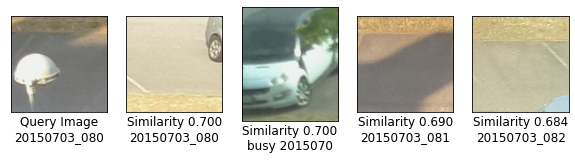

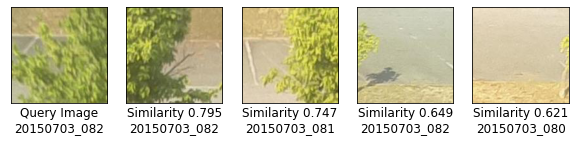

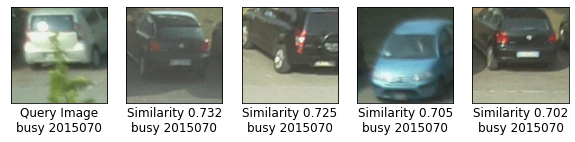

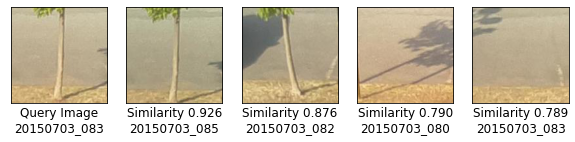

In [5]:
import matplotlib.pyplot as plt

# take some examples from the provided image set and plot
# inputImages = ["trees0.jpg", "camper0.jpg", "buildings0.jpg", "donkey0.jpg", "donkey_search.jpg", "kombi_search.jpg"]
inputImages = ["20150703_0805_34.jpg" , "20150703_0825_6.jpg",
                "busy 20150703_0840_2.jpg", "20150703_0830_24.jpg"]
# inputImages = ["20150703_0820_39.jpg", "busy 20150703_0920_14.jpg"] # search images

numCol = 5
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image[:12]), fontsize = 12)
    else:
        ax.set_xlabel("Similarity {1:1.3f}\n{0}".format(image[:12],  value), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    
def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal = 5)
            imgs.remove(image)
            vals.remove(max(vals))
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))
        
def plotSimilarImages(image, similarNames, similarValues):
    simImages, simValues = getSimilarImages(image, similarNames, similarValues)
    fig = plt.figure(figsize=(10, 20))
    
    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0:
            if os.path.exists(os.path.join(inputDir, image)):
                img = Image.open(os.path.join(inputDir, image))
            else:
                img = Image.open(os.path.join(searchDir, image))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else:
            img = Image.open(os.path.join(inputDir, simImages[j-1]))
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], simImages[j-1], value = simValues[j-1])
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    
    plt.show()
        
for image in inputImages:
    plotSimilarImages(image, similarNames, similarValues)
    
    
#show search image
# img = Image.open(os.path.join(searchDir, "donkey_search.jpg"))
# plt.imshow(img)
# img.close()


100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 1186.25it/s]


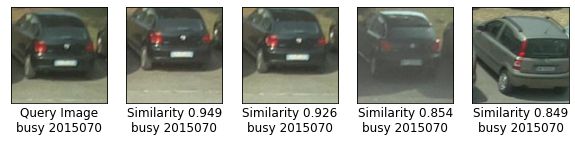

Wall time: 432 ms


In [7]:
%%time

# Add new image to feature vectors array
#searchImgName = "20150703_0820_39.jpg"
searchImgName = "busy 20150703_0920_14.jpg"
searchImg = Image.open(os.path.join(searchDir, searchImgName))

# resize and save to inputDirCNN
resizeAndSaveToInputDirCNN(searchDir, searchImgName, inputDirCNN)


convertImageToFeatureVector(searchImgName, allVectors)


similarityMatrix = getSimilarityMatrix(allVectors)

# prepareTopKLists(k, similarityMatrix)
newSimilarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
newSimilarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))

for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    newSimilarNames.iloc[j, :] = list(kSimilar.index)
    newSimilarValues.iloc[j, :] = kSimilar.values

plotSimilarImages(searchImgName, newSimilarNames, newSimilarValues)